## Milling Tool Wear Maintenance Policy using the REINFORCE algorithm

- Ver. 4.1: 01-May-2023 - Improved plots
- Ver. 4.5: 01-May-2023 - Add Stable-Baselines algo.
- Ver. 4.6: 02-May-2023 - Expt RF vs SB-3 PPO, scaled rewards: 1/10^6 

In [10]:
import numpy as np
import pandas as pd

import milling_tool_environment
from milling_tool_environment import MillingTool_V2
from utilities import plot_learning_curve, single_axes_plot, two_axes_plot, two_variable_plot, plot_error_bounds
from reinforce_classes import PolicyNetwork, Agent

In [34]:
import importlib
importlib.reload(milling_tool_environment)

<module 'milling_tool_environment' from 'D:\\Rajesh\\ResearchLab\\LG_\\milling_tool_environment.py'>

In [35]:
# Milling operation constants
WEAR_THRESHOLD = 3.0 # mm
WEAR_THRESHOLD_NORMALIZED = 1.0 # normalized to the max wear threshold
MILLING_OPERATIONS_MAX = 400
BREAKDOWN_CHANCE = 0.05

# Policy network learning parameters
gamma = 0.99
alpha = 0.01
EPISODES = 300 # Train for N episodes
PREFIX = 'Tool_Wear_04-May-2023'
DATA_FILE = 'Tool_Wear_VB.csv'

Tool wear data imported (121 records). WEAR_THRESHOLD_NORMALIZED: 0.168 




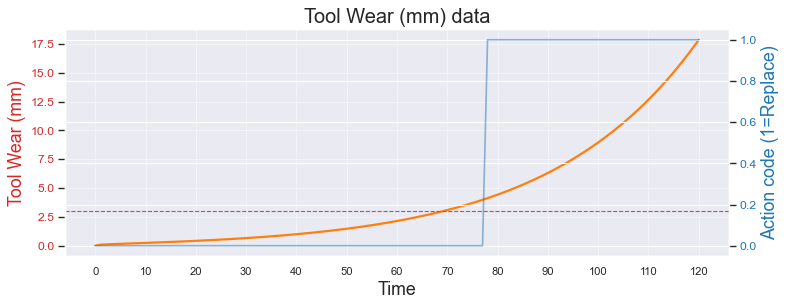

In [37]:
## Read data
df = pd.read_csv(DATA_FILE)
df = df[['time', 'VB_mm', 'ACTION_CODE']]

# Normalizing entire df with min-max scaling
WEAR_MIN = df['VB_mm'].min() 
WEAR_MAX = df['VB_mm'].max()
WEAR_THRESHOLD_NORMALIZED = (WEAR_THRESHOLD-WEAR_MIN)/(WEAR_MAX-WEAR_MIN)
df_normalized = (df-df.min())/(df.max()-df.min())
print(f'Tool wear data imported ({len(df.index)} records). WEAR_THRESHOLD_NORMALIZED: {WEAR_THRESHOLD_NORMALIZED:4.3f} \n\n')

## Visualize the data
n_records = len(df.index)
x = df['time'].values.tolist()
y1 = df['VB_mm'].values.tolist()
y2 = df['ACTION_CODE'].values.tolist()

two_axes_plot(x, y1, y2, title='Tool Wear (mm) data', x_label='Time', y1_label='Tool Wear (mm)', y2_label='Action code (1=Replace)', xticks=10,threshold=WEAR_THRESHOLD)

## REINFORCE RL Algorithm

In [ ]:
### Main loop
rewards_history = []
loss_history = []

env_RF = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, False, 0.0)

input_dim = env_RF.observation_space.shape[0]
output_dim = env_RF.action_space.n

agent_RF = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env_RF.reset()
    
    # Sample a trajectory
    for t in range(MILLING_OPERATIONS_MAX): # Max. milling operations desired
        action = agent_RF.act(state)
        state, reward, done, info = env_RF.step(action)
        agent_RF.rewards.append(reward)
        #env_RF.render()
        if done:
            print('** DONE **', info)
            break
            
    # Learn during this episode 
    loss = agent_RF.learn() # train per episode
    total_reward = sum(agent_RF.rewards)
    
    # Record statistics for this episode
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    
    # On-policy - so discard all data 
    agent_RF.onpolicy_reset()

    if (episode%1 ==0):
        print(f'[{episode:04d}] Loss: {loss:>10.2e} | Reward: {total_reward:>10.2e} | Ep.length: {env_RF.ep_length:04d}')

[0000] Loss:  -2.16e+02 | Reward:  -3.57e+00 | Ep.length: 0400
[0001] Loss:  -2.42e+02 | Reward:  -3.93e+00 | Ep.length: 0400
[0002] Loss:  -2.72e+02 | Reward:  -4.47e+00 | Ep.length: 0400
[0003] Loss:  -2.55e+02 | Reward:  -4.14e+00 | Ep.length: 0400
[0004] Loss:  -2.67e+02 | Reward:  -4.36e+00 | Ep.length: 0400
[0005] Loss:  -2.94e+02 | Reward:  -5.08e+00 | Ep.length: 0400
[0006] Loss:  -2.96e+02 | Reward:  -5.05e+00 | Ep.length: 0400
[0007] Loss:  -2.88e+02 | Reward:  -4.77e+00 | Ep.length: 0400
[0008] Loss:  -3.02e+02 | Reward:  -5.26e+00 | Ep.length: 0400
[0009] Loss:  -2.98e+02 | Reward:  -5.29e+00 | Ep.length: 0400
[0010] Loss:  -2.94e+02 | Reward:  -5.44e+00 | Ep.length: 0400
[0011] Loss:  -2.97e+02 | Reward:  -5.99e+00 | Ep.length: 0400
[0012] Loss:  -3.09e+02 | Reward:  -5.90e+00 | Ep.length: 0400
[0013] Loss:  -2.89e+02 | Reward:  -6.08e+00 | Ep.length: 0400
[0014] Loss:  -2.66e+02 | Reward:  -6.29e+00 | Ep.length: 0400
[0015] Loss:  -2.57e+02 | Reward:  -6.81e+00 | Ep.lengt

In [ ]:
x = [i for i in range(EPISODES)]

## Moving average for rewards
ma_window_size = 10
# # Convert error array to pandas series
rewards = pd.Series(rewards_history)
windows = rewards.rolling(ma_window_size)
moving_avg = windows.mean()
moving_avg_lst = moving_avg.tolist()
y1 = rewards
y2 = moving_avg_lst

filename = PREFIX + '_Avg_episode_rewards.png'
two_variable_plot(x, y1, y2, 'Avg. rewards per episode', 'Episode', 'Avg. Rewards', 'Moving Avg.', 10, filename)

plot_error_bounds(x, y1)

filename = PREFIX + '_Episode_Length.png'
single_axes_plot(x, env_RF.ep_length_history, 'Episode length', 'Episode', 'No of milling operations', 10, 0.0, filename)

filename = PREFIX + '_Tool_Replacements.png'
single_axes_plot(x, env_RF.ep_tool_replaced_history, 'Tool replacements per episode', 'Episode', 'Replacements', 10, 0.0, filename)

# filename = PREFIX + '_Avg_episode_rewards.png'
# single_axes_plot(x, rewards_history, 'Avg. rewards per episode', 'Episode', 'Avg.Reward', 10, 0.0, filename)
# plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, moving_avg_n=10, filename=filename) 


## Stable-Baselines Algorithms

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, PPO, DQN

In [ ]:
training_timesteps = 300
PREFIX = 'Tool_Wear_SB-3_01-May-2023_'

env_SB = MillingTool_V2(df_normalized, WEAR_THRESHOLD_NORMALIZED, MILLING_OPERATIONS_MAX, False, -1.0)
agent_SB = A2C('MlpPolicy', env_SB, verbose=1)
agent_SB.learn(total_timesteps=training_timesteps)

### Test Models

- REINFORCE algorithm: Environment = ```env_RF```, agent/model = ```agent_RF ```
- stable_baselines3 algorithm: Environment = ```env_SB```, agent/model = ```agent_SB ```

In [ ]:
# Create test cases
test_cases = np.random.randint(0, env_RF.df_length-1, 100)
test_cases = np.sort(test_cases)

#### Test-1: REINFORCE algorithm

In [ ]:
cumm_error_0 = 0.0
cumm_error_1 = 0.0
n_0 = 0
n_1 = 0
for idx in test_cases:
    state = env_RF._get_observation(idx)
    action_pred = agent_RF.act(state)
    action_actual = int(df_normalized['ACTION_CODE'][idx])
    e = int(action_pred - action_actual)
    if idx>77:
        cumm_error_0 += abs(e)
        n_0 += 1
        print(f' ** {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')
    else:
        cumm_error_1 += abs(e)
        n_1 += 1
        print(f'    {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')

if n_0 == 0: n_0 = 1
if n_1 == 0: n_1 = 1
print(50*'-', f'\n Test-1: REINFORCE algorithm (300 episodes)')
print(50*'-')
print(f' Avg. Error for NORMAL {n_0} cases: \t {cumm_error_0*100.00/n_0:6.2f} %')
print(f' Avg. Error for REPLACEMENT {n_1} cases: \t {cumm_error_1*100.00/n_1:6.2f} %')
print(f' Overall avg. error {n_0+n_1} cases: \t\t {(cumm_error_0 + cumm_error_1)*100.00/(n_0+n_1):6.2f} %')
print(50*'=')
print(f'RF\t{n_0}\t{cumm_error_0/n_0:5.3f}\t{n_1}\t{cumm_error_1/n_1:5.3f}\t{(cumm_error_0 + cumm_error_1)/(n_0+n_1):5.3f}')

## Stable Baselines Test

cumm_error_0 = 0.0
cumm_error_1 = 0.0
n_0 = 0
n_1 = 0
for idx in test_cases:
    state = env_SB._get_observation(idx)
    action_pred, next_state = agent_SB.predict(state)
    action_actual = int(df['ACTION_CODE'][idx])
    e = int(action_pred - action_actual)
    if idx>77:
        cumm_error_0 += abs(e)
        n_0 += 1
        print(f' ** {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')
    else:
        cumm_error_1 += abs(e)
        n_1 += 1
        print(f'    {idx:4d}: VB (mm): {state[1]*17.855:6.3f} \t Action predicted: {action_pred} \t actual: {action_actual} \t error: {e}')

if n_0 == 0: n_0 = 1
if n_1 == 0: n_1 = 1
print(50*'-', f'\n Test-2: Stable Baselines algorithm (3k episodes)')
print(50*'-')
print(f' Avg. Error for NORMAL {n_0} cases: \t {cumm_error_0*100.00/n_0:6.2f} %')
print(f' Avg. Error for REPLACEMENT {n_1} cases: \t {cumm_error_1*100.00/n_1:6.2f} %')
print(f' Overall avg. error {n_0+n_1} cases: \t\t {(cumm_error_0 + cumm_error_1)*100.00/(n_0+n_1):6.2f} %')
print(50*'=')
print(f'PPO\t{n_0}\t{cumm_error_0/n_0:5.3f}\t{n_1}\t{cumm_error_1/n_1:5.3f}\t{(cumm_error_0 + cumm_error_1)/(n_0+n_1):5.3f}')